In [1]:
#necessary imports
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import GreaterThan
from torch.optim import Adam
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#model definition and overall setup

def setup_model(train_X, train_Y):
    #setup the GP model
    model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
    #setup the noise constraints
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
    #setup the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    #setup to specific dtype
    mll = mll.to(train_X)
    #define optimizer
    optimizer = Adam([{"params": model.parameters()}], lr=0.1)

    return model, mll, optimizer

In [3]:
#General setup:
#use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
print(device)

cpu


In [4]:
#training loop: trains the model on the current available data
def train_loop(gp_model: SingleTaskGP, mll: ExactMarginalLogLikelihood, optimizer: Adam, train_X: torch.Tensor, train_Y: torch.Tensor, num_epochs: int):
    gp_model.train()

    for epoch in range(num_epochs):
        #clear gradients
        optimizer.zero_grad()
        #forward pass through the model to obtain the output MultivariateNormal
        output = gp_model(train_X)
        #Compute negative marginal log likelihood
        loss = -mll(output, gp_model.train_targets) #ANNOTATION: this was changed here from gp_model.train_targets to train_Y - what difference does it make?
        #back prop gradients
        loss.backward()
        #print every 10 iterations
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1:>3}/{num_epochs} - Loss: {loss.item():>4.3f} "
                f"lengthscale: {gp_model.covar_module.base_kernel.lengthscale.item():>4.3f} "
                f"noise: {gp_model.likelihood.noise.item():>4.3f}"
            )
        optimizer.step()


In [5]:
#define acquisition function and optimize it based on the currently trained model: returns next parameter setting to observe in real world

#add bounds as input?

def return_next_parameter_setting(gp_model: SingleTaskGP, train_X: torch.Tensor, train_Y: torch.Tensor, bounds: torch.tensor):
    #acquisition function set here to maximization!
    EI = ExpectedImprovement(model=gp_model, best_f=train_Y.max(), maximize=True)
    candidate, acq_value = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        #looking for the next single best point:
        q=1,
        #number of times the optimization restarts to avoid local maxima:
        num_restarts=80,
        #number of randomly sampled points used to initilize the optimization of the acquisition function
        raw_samples=400,  # Vary depending on the problem
    )

    # UCB = UpperConfidenceBound(model=gp_model, beta=3.0)  # Tune beta as needed
    # candidate, acq_value = optimize_acqf(
    #     acq_function=UCB,
    #     bounds=bounds,
    #     q=1,
    #     num_restarts=20,
    #     raw_samples=100,
    # )

    print(f"Next suggested x-point: {candidate}")
    return candidate


In [6]:
#acquire new observation data

def acquire_datapoint(candidate: torch.Tensor, function: callable):
    #extract scalar value
    point_to_evaluate = candidate.squeeze()
    #extract point - add dimension to be able to use it in the gt_function later
    function_value = function(point_to_evaluate.unsqueeze(-1))
    function_value = function_value.unsqueeze(1)
    print(f"Next acquired y-point: {function_value}")
    return function_value


In [7]:
#function to show the currently trained model and the acquisition function graph below it in a seperate 

def plot_gp_and_acquisition(model, train_X, train_Y, bounds, ax=None):
    #set model to eval mode
    model.eval()

    #define points for plotting
    with torch.no_grad():
        #range of points for plotting
        test_x = torch.linspace(bounds[0, 0], bounds[1, 0], 100).unsqueeze(-1)  # Corrected access here
        test_x = test_x.to(train_X.device, dtype=train_X.dtype)
        test_x = test_x.unsqueeze(-2)  # Add batch dimension for acquisition function
        posterior = model.posterior(test_x)
        mean = posterior.mean.squeeze(-1)
        #get lower and upper confidence bounds (2 standard deviations)
        lower, upper = posterior.mvn.confidence_region()

    # Plotting the GP mean and confidence interval
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    # For plotting, remove the batch dimension
    test_x_plot = test_x.squeeze(-2).detach()  # Adjust shape for plotting

    ax[0].plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'ko')
    ax[0].plot(test_x_plot.cpu().numpy(), mean.cpu().numpy(), 'b')
    ax[0].fill_between(test_x.cpu().numpy().flatten(), lower.cpu().numpy().flatten(), upper.cpu().numpy().flatten(), alpha=0.5)  # Flatten the tensors to make them 1D    ax[0].set_title("Gaussian Process and Observed Data")
    ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
    
    # Acquisition function plot
    EI = ExpectedImprovement(model=model, best_f=standardize(train_Y).max(), maximize=True)
    acq_values = EI(test_x).detach()

    ax[1].plot(test_x_plot.cpu().numpy(), acq_values.cpu().numpy(), 'g-')
    ax[1].set_title("Acquisition Function")
    ax[1].set_xlabel("Input space")
    ax[1].set_ylabel("Acquisition Value")
    
    plt.tight_layout()
    plt.show()

In [8]:
#Update old dataset: 

def update_dataset(old_data_X: torch.tensor, old_data_Y: torch.tensor, new_single_X: torch.tensor, new_single_Y: torch.tensor):
    
    new_train_X = torch.cat([old_data_X, new_single_X], 0)
    new_train_Y = torch.cat([old_data_Y, new_single_Y], 0)

    return new_train_X, new_train_Y

In [9]:
#function to implement the new point in the training data and refine the model: condition_on_observations

def refine_gp_model(gp_model: SingleTaskGP, new_train_X, new_train_Y):
    #return the refined model:
    # TODO: detaching the data is necessary?
    return gp_model.condition_on_observations(new_train_X, new_train_Y)

In [10]:
#setup initial dataset
#use regular spaced points on the interval [0, 6] -> here 4 equally spaced points between 0 and 6
train_X = torch.linspace(0, 6, 2, dtype=dtype, device=device)
#training data needs to be explicitly multi-dimensional, here from 1-dimensional to 2-dimensional
train_X = train_X.unsqueeze(1)

#setup function: 

def gt_function(x_values: torch.tensor):
    #original function: x*sin(x) with added noise
    return x_values * torch.sin(x_values) + 0.2 * torch.randn_like(x_values)

#sample observed values and add some synthetic noise
train_Y = gt_function(train_X)

In [15]:
train_X.shape

torch.Size([2, 1])

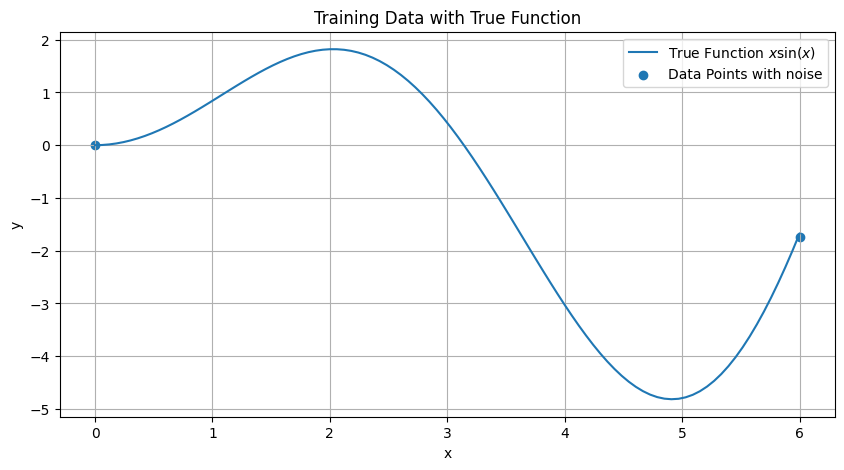

In [11]:
# Define a fine grid over the interval [0, 6] for plotting the true function
x_values = torch.linspace(0, 6, 100).unsqueeze(1)
y_values = x_values * torch.sin(x_values)

#Plotting the noise data points and the original function x*sin(x)
plt.figure(figsize=(10, 5))
plt.plot(x_values.cpu().numpy(), y_values.cpu().numpy(), label='True Function $x\sin(x)$')
plt.scatter(train_X.cpu().numpy(), train_Y.cpu().numpy(), label='Data Points with noise')
plt.title('Training Data with True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [450]:
#iterative loop function: 

def optimization_loop(model: SingleTaskGP, train_X: torch.tensor, train_Y: torch.tensor, n_iterations: int, bounds: torch.tensor):

    for iteration in range(n_iterations):
        #plot the graph and acquisition function
        plot_gp_and_acquisition(model, train_X, train_Y, bounds) 
        #determine next parameter setting:
        next_x_setting = return_next_parameter_setting(model, train_X, train_Y, bounds)
        #acquire next observation value: 
        next_y_observation = acquire_datapoint(next_x_setting, gt_function)
        #update the dataset:
        train_X, train_Y = update_dataset(train_X, train_Y, next_x_setting, next_y_observation)
        #redefine model:
        model = refine_gp_model(model, train_X, train_Y)

        

In [451]:
#optimization and training in one loop:

def training_optimization_loop(model: SingleTaskGP, mll, optimizer: Adam, train_X: torch.tensor, train_Y: torch.tensor, n_iterations: int, bounds: torch.tensor, num_epochs: int):

    #initial training of the model: 
    train_loop(model, mll, optimizer, train_X, train_Y, num_epochs)

    #optimization loop: 
    optimization_loop(model, train_X, train_Y, n_iterations, bounds)

In [13]:
model, mll, optimizer = setup_model(train_X, train_Y)

c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.8596], dtype=torch.float64), std = tensor([1.2323], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [14]:
print(type([{"params": model.parameters()}]))

<class 'list'>


In [12]:
#run loop:
bounds = torch.tensor([[0.0], [6.0]], dtype=torch.float32)
n_iterations = 10

model, mll, optimizer = setup_model(train_X, train_Y)

print(f"initial x-points: {train_X}")
print(f"initial y-points: {train_Y}")

training_optimization_loop(model, mll, optimizer, train_X, train_Y, n_iterations=30, bounds=bounds, num_epochs=150)



c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.8596], dtype=torch.float64), std = tensor([1.2323], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


initial x-points: tensor([[0.],
        [6.]], dtype=torch.float64)
initial y-points: tensor([[ 0.0118],
        [-1.7310]], dtype=torch.float64)


NameError: name 'training_optimization_loop' is not defined

In [ ]:
print(type([{"params": model.parameters()}]))

In [ ]:
#Is this important for me? What effect does it have?
'''
If targets is a batch (e.g. b x m), 
then the GP returned from this method will be a batch mode GP. 
If inputs is of the same (or lesser) dimension as targets, 
then it is assumed that the fantasy points are the same for each target batch.
'''

In [ ]:
'''
Open questions: 
-Stopping criteria? When do i stop the observation-optimization-loop? - Probably over the acquisition function
-When to retrain the hyperparameter setup?
-How do i exactly incorporate the noise or more specific: how do I set the noise level constraints in a correct way? I determine them from the dataset? How is the lower bound set?
-Should i package everything into one bigger loop? What is then the stop criteria? - Should be dependent on the acquisition function
'''